# Member Contributions

### First, set the start and end dates and filter out the states that we need to analyze. In my case, my states are California, Idaho, Washington State, Oregon, Wyoming, and Montana. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

super_covid19_data = pd.read_csv(r"C:\Users\bluev\Downloads\Group7ClassProject\Stage I\Team\super_covid19_data.csv")

# Filter for cases between June 01 2020 and January 3 2021
start_date = '2020-06-01'
end_date = '2021-01-04' 

# Filter for columns between the start_date and end_date for cases and deaths
all_columns = super_covid19_data.columns
filtered_columns = all_columns[(all_columns >= start_date) & (all_columns <= end_date)]

# Create a filtered DataFrame with only the relevant date columns
filtered_super_covid19_data = super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population'] + list(filtered_columns)]

# US state abbreviations: CA ID WA OR WY MT
states_to_keep = ['CA', 'ID', 'WA', 'OR', 'WY', 'MT']

# Filter the DataFrame to keep only the rows for these states
filtered_super_covid19_data = filtered_super_covid19_data[filtered_super_covid19_data['State'].isin(states_to_keep)]

# Save the filtered dataset to a CSV file
filtered_super_covid19_data.to_csv('filtered_super_dates_June2020_Jan2021_and_6_states.csv', index=False)

#### Aggregate data into weekly columns (similar to our Country Data set):

In [3]:
# Filter case columns
case_columns = [col for col in filtered_super_covid19_data.columns if '_cases' in col]

# Transpose the case columns to resample by week
case_data = filtered_super_covid19_data[case_columns].T

# Convert column names (remove the suffix and convert to datetime)
case_data.index = pd.to_datetime([col[:10] for col in case_columns])

# Resample by week (summing cases for each week)
weekly_cases = case_data.resample('W-SUN').sum()

# Calculate the weekly differences to get non-cumulative data
weekly_non_cumulative_cases = weekly_cases.diff().fillna(weekly_cases.iloc[0])

# Transpose back and rename the columns to indicate weeks
weekly_non_cumulative_cases = weekly_non_cumulative_cases.T
weekly_non_cumulative_cases.columns = [str(col.date()) + '_cases' for col in weekly_non_cumulative_cases.columns]

# Combine with non-date columns that contain state and county info
weekly_non_cumulative_cases_super_covid19_data = pd.concat(
    [filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], 
    weekly_non_cumulative_cases], 
    axis=1)

# Remove rows that do not have info on the number of cases
weekly_non_cumulative_cases_super_covid19_data = weekly_non_cumulative_cases_super_covid19_data[
    weekly_non_cumulative_cases_super_covid19_data['countyFIPS'] != 0]

#### Do the same for deaths:

In [5]:
# Filter the death columns
death_columns = [col for col in filtered_super_covid19_data.columns if '_deaths' in col]

# Transpose the death columns to resample by week
death_data = filtered_super_covid19_data[death_columns].T

# Convert column names (remove the suffix and convert to datetime)
death_data.index = pd.to_datetime([col[:10] for col in death_columns])

# Resample by week (summing deaths for each week)
weekly_deaths = death_data.resample('W-SUN').sum()

# Calculate non-cumulative weekly deaths by taking the difference between consecutive weeks
non_cumulative_weekly_deaths = weekly_deaths.diff().fillna(weekly_deaths)

# Transpose back and rename the columns to indicate weeks
non_cumulative_weekly_deaths = non_cumulative_weekly_deaths.T
non_cumulative_weekly_deaths.columns = [str(col.date()) + '_deaths' for col in non_cumulative_weekly_deaths.columns]

# Combine with non-date columns that contain state and county info
non_cumulative_weekly_deaths_super_covid19_data = pd.concat(
    [filtered_super_covid19_data[['countyFIPS', 'State', 'County Name_x', 'population']], 
    non_cumulative_weekly_deaths], 
    axis=1)

# Remove rows that do not have info on the number of deaths
non_cumulative_weekly_deaths_super_covid19_data = non_cumulative_weekly_deaths_super_covid19_data[
    non_cumulative_weekly_deaths_super_covid19_data['countyFIPS'] != 0]

### Weekly Statistics (For California cases, in my case) and generate the appropriate line plot:

California weekly cases statistics: 

Mean weekly cases: 9296.077011494252
Median weekly cases: 1234.5
Mode weekly cases: 0    0.0
Name: 0, dtype: float64


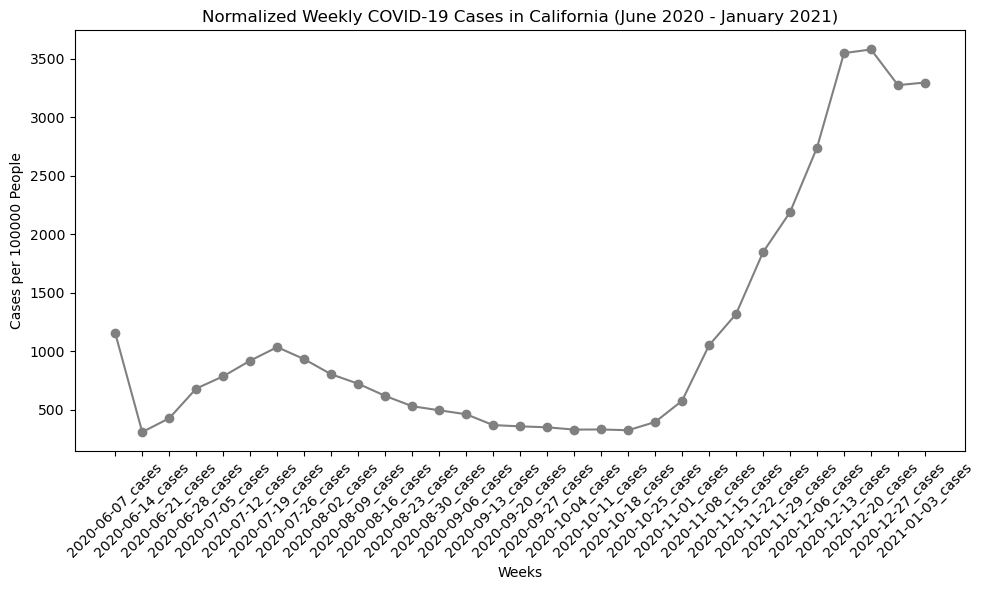

In [7]:
# Remove rows that don't contain 'CA' in the State column
ca_weekly_cases = weekly_non_cumulative_cases_super_covid19_data[
    weekly_non_cumulative_cases_super_covid19_data['State'].str.contains('CA') == True]

# Identify the columns for weekly cases
ca_weekly_case_columns = [col for col in ca_weekly_cases.columns if '_cases' in col]

# Calculate the average weekly cases for each county excluding the first week
county_avg_weekly_cases = ca_weekly_cases[ca_weekly_case_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
ca_weekly_cases.loc[:, ca_weekly_case_columns[0]] = county_avg_weekly_cases

# Save a copy to use later for the 5 counties of my choice
ca_weekly_cases.to_csv('CA_weekly_cases.csv', index=False)

# The mean, median, and mode across all weeks
overall_mean = ca_weekly_cases[ca_weekly_case_columns].mean().mean()  
overall_median = ca_weekly_cases[ca_weekly_case_columns].median().median()  
ca_weekly_case_modes = ca_weekly_cases[ca_weekly_case_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode = ca_weekly_case_modes.mode()

# Print the mean, median, and mode
print("California weekly cases statistics: \n")
print("Mean weekly cases:", overall_mean)
print("Median weekly cases:", overall_median)
print("Mode weekly cases:", overall_mode)

# Normalize each week's cases by the population per 100000 individuals for each county
normalized_ca_weekly_cases = ca_weekly_cases[ca_weekly_case_columns].div(ca_weekly_cases['population'], axis=0) * 100000

# Sum normalized cases for each week across all counties
ca_weekly_cases_normalized_sum = normalized_ca_weekly_cases.mean()

# Plot the normalized weekly cases
plt.figure(figsize=(10, 6))
plt.plot(ca_weekly_case_columns, ca_weekly_cases_normalized_sum, marker='o', linestyle='-', color='gray')
plt.title('Normalized Weekly COVID-19 Cases in California (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Cases per 100000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('normal_weekly_cases.jpg')  
plt.show()



### Do the same for deaths



California weekly deaths statistics: 

Mean weekly deaths: 111.24137931034481
Median weekly deaths: 13.0
Mode weekly deaths: 0    0.0
Name: 0, dtype: float64


C:\Users\bluev\AppData\Local\Temp\ipykernel_25980\2361828897.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_weekly_deaths[ca_weekly_death_columns[0]] = county_avg_weekly_deaths


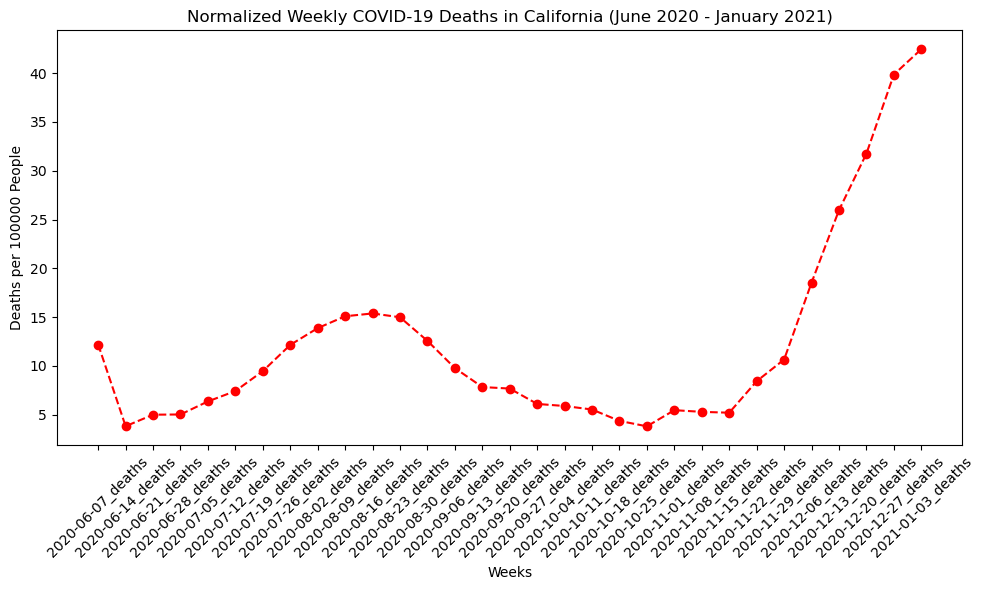

In [9]:
print('\n')

# Remove rows that don't contain 'CA' in the State column
ca_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data[
    non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains('CA') == True]

# Identify the columns for weekly deaths
ca_weekly_death_columns = [col for col in ca_weekly_deaths.columns if '_deaths' in col]

# Calculate the average weekly deaths for each county excluding the first week
county_avg_weekly_deaths = ca_weekly_deaths[ca_weekly_death_columns[1:]].mean(axis=1)

# Replace the first week's values with the calculated average for each county
ca_weekly_deaths[ca_weekly_death_columns[0]] = county_avg_weekly_deaths

# Save a copy to use later for the 5 counties of my choice
ca_weekly_deaths.to_csv('CA_weekly_deaths.csv', index=False)

# The mean, median, and mode across all weeks for deaths
overall_mean_deaths = ca_weekly_deaths[ca_weekly_death_columns].mean().mean()  
overall_median_deaths = ca_weekly_deaths[ca_weekly_death_columns].median().median()  
weekly_death_modes = ca_weekly_deaths[ca_weekly_death_columns].mode().iloc[0]  # First mode value of all weeks

overall_mode_deaths = weekly_death_modes.mode()

# Print the mean, median, and mode for weekly deaths
print("California weekly deaths statistics: \n")
print("Mean weekly deaths:", overall_mean_deaths)
print("Median weekly deaths:", overall_median_deaths)
print("Mode weekly deaths:", overall_mode_deaths)

# Normalize each week's deaths by the population per 100000 individuals for each county
normalized_ca_weekly_deaths = ca_weekly_deaths[ca_weekly_death_columns].div(ca_weekly_deaths['population'], axis=0) * 100000

# Sum normalized deaths for each week across all counties
ca_weekly_deaths_normalized_sum = normalized_ca_weekly_deaths.mean()

# Plot the normalized weekly deaths
plt.figure(figsize=(10, 6))
plt.plot(ca_weekly_death_columns, ca_weekly_deaths_normalized_sum, marker='o', linestyle='--', color='r')
plt.title('Normalized Weekly COVID-19 Deaths in California (June 2020 - January 2021)')
plt.xlabel('Weeks')
plt.ylabel('Deaths per 100000 People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('normal_weekly_deaths.jpg')  # You can specify the filename and format
plt.show()

### Create a line plot for the cases and deaths for the other states of mine:

ID weekly cases statistics:
Mean weekly cases: 728.0136363636366
Median weekly cases: 193.5
Mode weekly cases: 0.0

ID weekly deaths statistics:
Mean weekly deaths: 7.090151515151515
Median weekly deaths: 0.0
Mode weekly deaths: 0.0

--------------------------------------------------

WA weekly cases statistics:
Mean weekly cases: 1290.742735042735
Median weekly cases: 262.0
Mode weekly cases: 0.0

WA weekly deaths statistics:
Mean weekly deaths: 12.067521367521369
Median weekly deaths: 1.0
Mode weekly deaths: 0.0

--------------------------------------------------

OR weekly cases statistics:
Mean weekly cases: 701.9703703703705
Median weekly cases: 119.5
Mode weekly cases: 0.0

OR weekly deaths statistics:
Mean weekly deaths: 8.466666666666667
Median weekly deaths: 0.0
Mode weekly deaths: 0.0

--------------------------------------------------

WY weekly cases statistics:
Mean weekly cases: 439.93043478260876
Median weekly cases: 148.0
Mode weekly cases: 0.0

WY weekly deaths statist

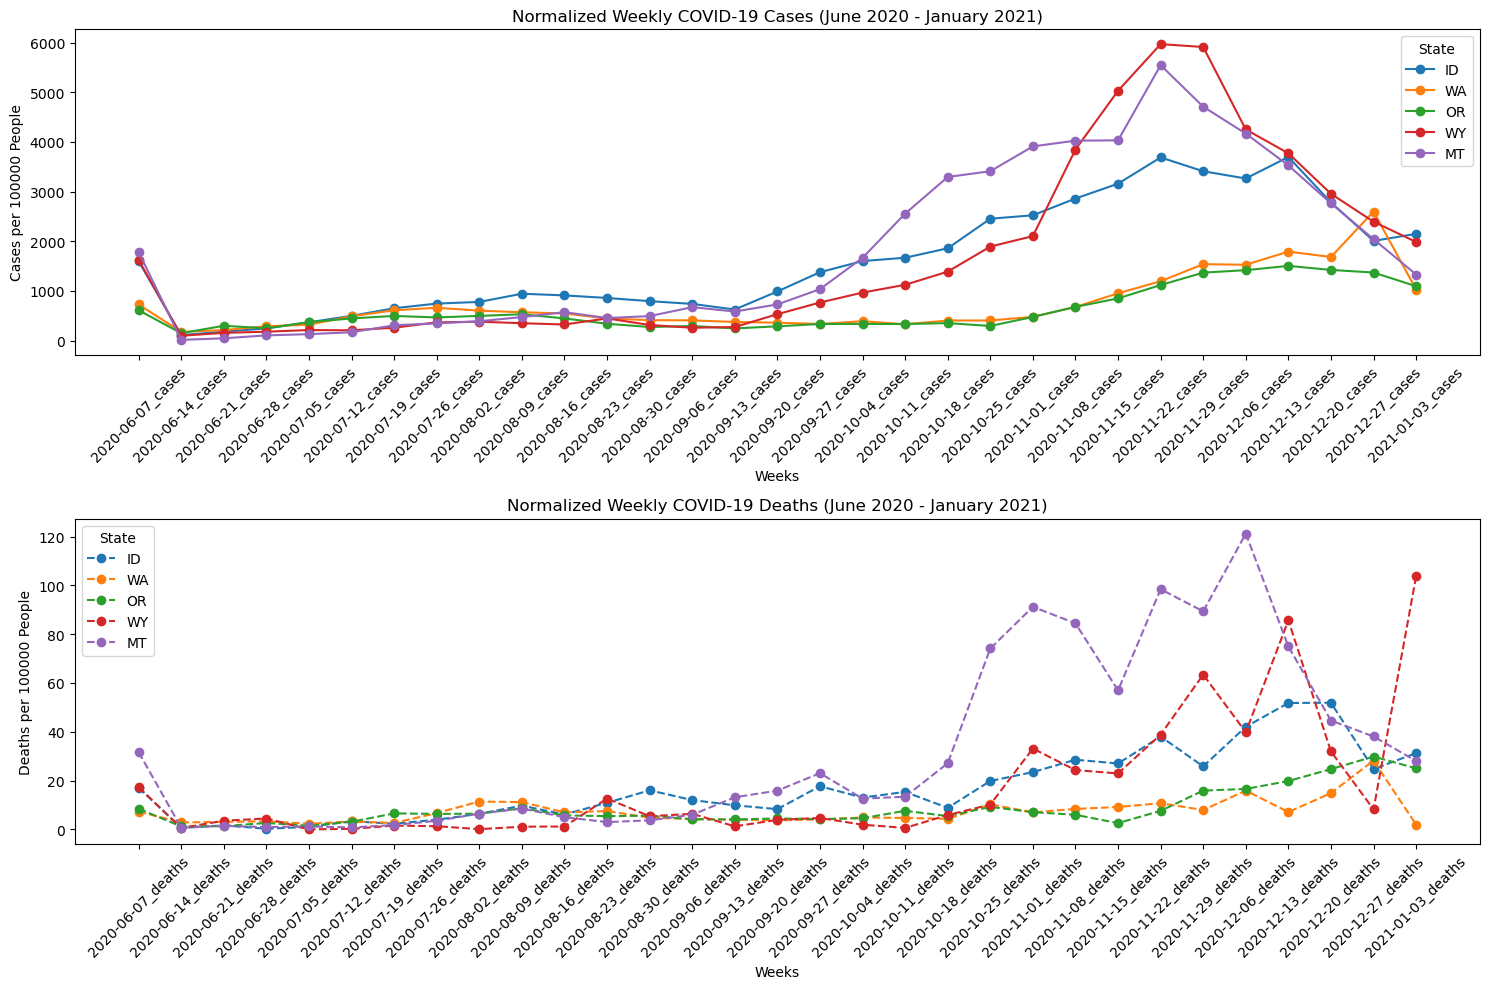

In [11]:
# The other 5 states to plot on a graph
states = ['ID', 'WA', 'OR', 'WY', 'MT']

# Create figure for combined plots
plt.figure(figsize=(15, 10))

# Iterate through each state and calculate weekly statistics
for state in states:
    # Filter for the specific state
    state_weekly_cases = weekly_non_cumulative_cases_super_covid19_data[
        weekly_non_cumulative_cases_super_covid19_data['State'].str.contains(state) == True]
    state_weekly_deaths = non_cumulative_weekly_deaths_super_covid19_data[
        non_cumulative_weekly_deaths_super_covid19_data['State'].str.contains(state) == True]

    # Identify the columns for weekly cases and deaths
    weekly_case_columns = [col for col in state_weekly_cases.columns if '_cases' in col]
    weekly_death_columns = [col for col in state_weekly_deaths.columns if '_deaths' in col]

    # Calculate the average weekly cases and deaths for each county excluding the first week
    county_avg_weekly_cases = state_weekly_cases[weekly_case_columns[1:]].mean(axis=1)
    county_avg_weekly_deaths = state_weekly_deaths[weekly_death_columns[1:]].mean(axis=1)

    # Replace the first week's values with the calculated average for each county
    state_weekly_cases.loc[:, weekly_case_columns[0]] = county_avg_weekly_cases
    state_weekly_deaths.loc[:, weekly_death_columns[0]] = county_avg_weekly_deaths

    # Calculate mean, median, and mode for weekly cases
    overall_mean_cases = state_weekly_cases[weekly_case_columns].mean().mean()  
    overall_median_cases = state_weekly_cases[weekly_case_columns].median().median()  
    state_weekly_case_modes = state_weekly_cases[weekly_case_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_cases = state_weekly_case_modes.mode()[0]  # Mode of the mode values

    # Calculate mean, median, and mode for weekly deaths
    overall_mean_deaths = state_weekly_deaths[weekly_death_columns].mean().mean()  
    overall_median_deaths = state_weekly_deaths[weekly_death_columns].median().median()  
    state_weekly_death_modes = state_weekly_deaths[weekly_death_columns].mode().iloc[0]  # First mode value of all weeks
    overall_mode_deaths = state_weekly_death_modes.mode()[0]  # Mode of the mode values

    # Print statistics for the current state
    print(f"{state} weekly cases statistics:")
    print("Mean weekly cases:", overall_mean_cases)
    print("Median weekly cases:", overall_median_cases)
    print("Mode weekly cases:", overall_mode_cases)
    print()

    print(f"{state} weekly deaths statistics:")
    print("Mean weekly deaths:", overall_mean_deaths)
    print("Median weekly deaths:", overall_median_deaths)
    print("Mode weekly deaths:", overall_mode_deaths)
    print('\n' + '-'*50 + '\n')

    # Normalize weekly cases and deaths by population per 100000 individuals
    normalized_weekly_cases = state_weekly_cases[weekly_case_columns].div(state_weekly_cases['population'], axis=0) * 100000
    normalized_weekly_deaths = state_weekly_deaths[weekly_death_columns].div(state_weekly_deaths['population'], axis=0) * 100000

    # Sum normalized cases and deaths for each week across all counties
    weekly_cases_normalized_sum = normalized_weekly_cases.mean()
    weekly_deaths_normalized_sum = normalized_weekly_deaths.mean()

    # Plot normalized weekly cases for the state
    plt.subplot(2, 1, 1)
    plt.plot(weekly_case_columns, weekly_cases_normalized_sum, marker='o', linestyle='-', label=state)
    plt.title('Normalized Weekly COVID-19 Cases (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Cases per 100000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

    # Plot normalized weekly deaths for the state
    plt.subplot(2, 1, 2)
    plt.plot(weekly_death_columns, weekly_deaths_normalized_sum, marker='o', linestyle='--', label=state)
    plt.title('Normalized Weekly COVID-19 Deaths (June 2020 - January 2021)')
    plt.xlabel('Weeks')
    plt.ylabel('Deaths per 100000 People')
    plt.xticks(rotation=45)
    plt.legend(title='State')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('normal_weekly_5_states.jpg')  # You can specify the filename and format
plt.show()

### Identify five counties within a state of your choice with high cases and death rates (in my case, California):

# COVID-19 Weekly Cases and Deaths Comparison (June 2020 - January 2021)

### Overview
The following analysis compares normalized weekly COVID-19 cases and deaths per 100,000 people for five states: Idaho (ID), Washington (WA), Oregon (OR), Wyoming (WY), and Montana (MT) between June 2020 and January 2021. The graphs provide insights into the peaks and trends across the states during this period.

---

## 1. Identifying Peaks

- **Normalized Weekly Cases (Top Graph)**:
  - **Montana (MT)** shows the most pronounced peak, reaching **over 6000 cases per 100,000 people** around **November 2020**.
  - **Wyoming (WY)** follows closely with a sharp peak, reaching just above **5000 cases per 100,000 people** in the same time frame.
  - **Idaho (ID)** has a moderate peak around **4000 cases per 100,000 people** in **November 2020**.
  - **Washington (WA)** and **Oregon (OR)** remain relatively lower, peaking around **2000 cases per 100,000 people** in **December 2020**.

- **Normalized Weekly Deaths (Bottom Graph)**:
  - **Wyoming (WY)** leads with the highest peak in deaths, surpassing **100 deaths per 100,000 people** in **December 2020**.
  - **Montana (MT)** also shows significant peaks, crossing **70 deaths per 100,000 people** in **November 2020**.
  - **Idaho (ID)** reaches a peak of approximately **50 deaths per 100,000 people** around **December 2020**.
  - **Washington (WA)** and **Oregon (OR)** show relatively lower death rates, peaking below **20 deaths per 100,000 people**.

---

## 2. Explaining Differences Across States

Several factors contribute to the differing COVID-19 rates among these states:

### Population Density
- States like **Washington** and **Oregon** have more densely populated urban centers (Seattle, Portland), which may have had better public health resources and interventions, leading to lower peaks in both cases and deaths.
- In contrast, **Montana** and **Wyoming**, being less densely populated, initially saw fewer cases but later faced severe outbreaks, likely due to less healthcare infrastructure and delayed interventions.

### State Policies
- **Washington** and **Oregon** implemented stricter public health measures such as mask mandates and lockdowns, which helped manage the spread of the virus.
- States like **Idaho**, **Wyoming**, and **Montana** had more relaxed restrictions or slower responses, contributing to higher transmission rates, especially during the surge in late 2020.

### Healthcare Infrastructure
- **Washington** and **Oregon** have more robust healthcare systems, which likely helped manage severe cases better, resulting in lower death rates compared to **Montana** and **Wyoming**, where healthcare resources, especially in rural areas, are more limited.

### Public Compliance
- Variations in public compliance with social distancing, mask-wearing, and other health guidelines across the states may have contributed to the spikes in cases and deaths. States like **Montana** and **Wyoming** may have experienced more significant outbreaks due to lower adherence to preventive measures.

---

### Conclusion

The differences in COVID-19 case and death rates across these five states can be attributed to a combination of public health policies, population density, healthcare access, and the state's response to the pandemic. The data highlights the importance of timely interventions and adequate healthcare infrastructure in mitigating the impacts of the pandemic.


### Generate the appropriate graph

### Now show the log normalized values:

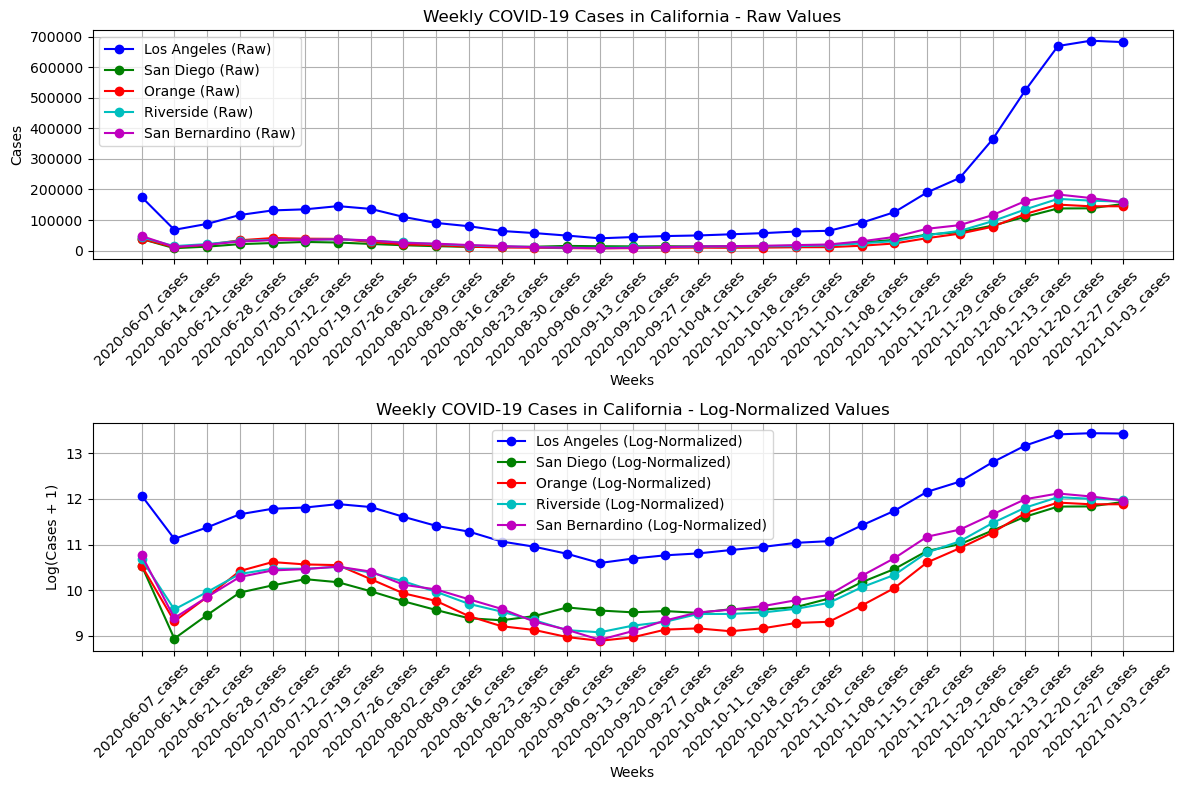

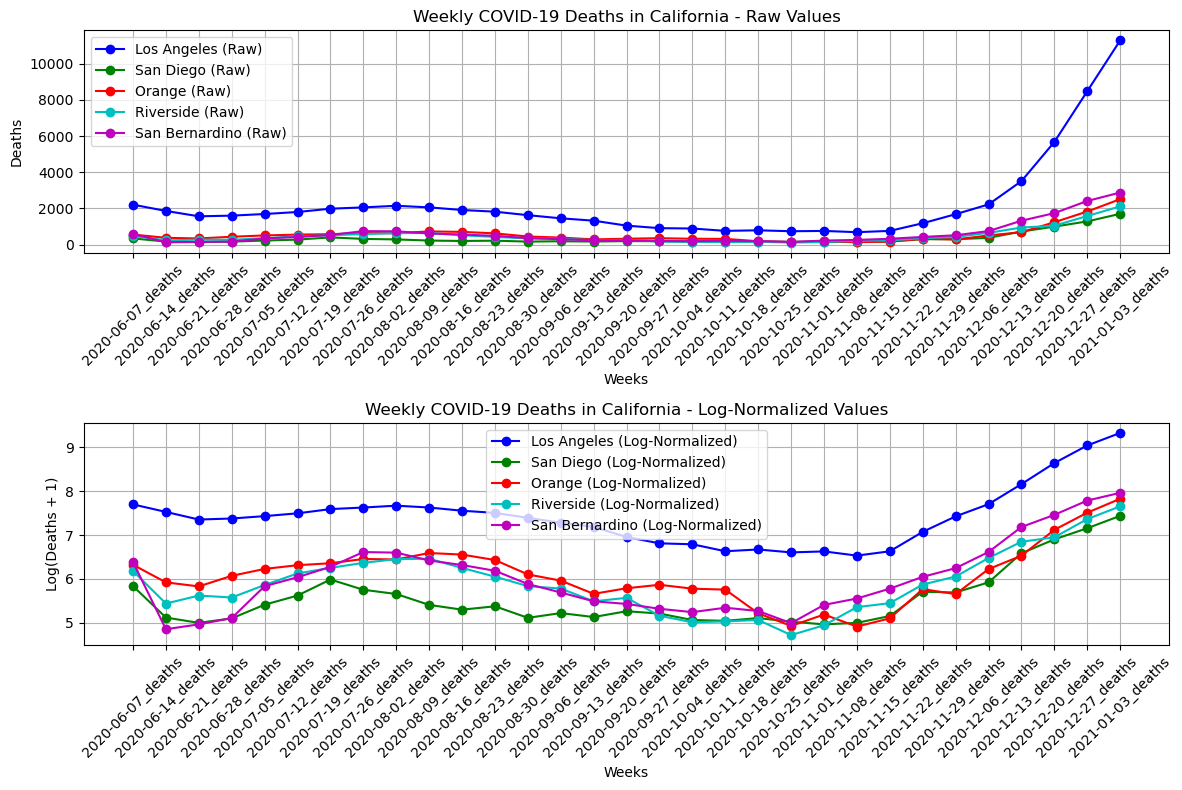

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace file names to read California data
df_cases = pd.read_csv('CA_weekly_cases.csv')
df_deaths = pd.read_csv('CA_weekly_deaths.csv')

# 5 chosen counties in California
desired_counties = ['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'San Bernardino']

# Regex pattern that matches any of the desired counties followed by " County"
pattern = '|'.join([f'{county} County' for county in desired_counties])

# Filter the rows in df_cases where 'County Name_x' matches the pattern
df_ca_cases_filtered = df_cases[df_cases['County Name_x'].str.contains(pattern, regex=True)]

# Filter the rows in df_deaths where 'County Name_x' matches the pattern
df_ca_deaths_filtered = df_deaths[df_deaths['County Name_x'].str.contains(pattern, regex=True)]

county_colors = ['b', 'g', 'r', 'c', 'm']  # Different colors for each county

weekly_case_columns = [col for col in df_ca_cases_filtered.columns if '_cases' in col]
weekly_death_columns = [col for col in df_ca_deaths_filtered.columns if '_deaths' in col]

def plot_raw_and_log(data, columns, title, ylabel, color_list, filename):
    plt.figure(figsize=(12, 8))

    # Plot Raw Values
    plt.subplot(2, 1, 1)
    for i, county in enumerate(desired_counties):
        county_data = data[data['County Name_x'].str.contains(county)]
        plt.plot(columns, county_data[columns].sum(), label=f'{county} (Raw)', marker='o', color=color_list[i])
    plt.title(f'{title} - Raw Values')
    plt.xlabel('Weeks')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot Log-Normalized Values
    plt.subplot(2, 1, 2)
    for i, county in enumerate(desired_counties):
        county_data = data[data['County Name_x'].str.contains(county)]
        log_values = np.log1p(county_data[columns].sum())  # log1p for log(1 + x)
        plt.plot(columns, log_values, label=f'{county} (Log-Normalized)', marker='o', color=color_list[i])
    plt.title(f'{title} - Log-Normalized Values')
    plt.xlabel('Weeks')
    plt.ylabel(f'Log({ylabel} + 1)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(filename)  # Save the figure with the provided filename
    plt.show()

# Plotting for California data
plot_raw_and_log(
    df_ca_cases_filtered, 
    weekly_case_columns, 
    'Weekly COVID-19 Cases in California', 
    'Cases', 
    county_colors, 
    'weekly_cases_raw_and_log.jpg'
)

plot_raw_and_log(
    df_ca_deaths_filtered, 
    weekly_death_columns, 
    'Weekly COVID-19 Deaths in California', 
    'Deaths', 
    county_colors, 
    'weekly_deaths_raw_and_log.jpg'
)


# Analysis of Top 5 Counties in California (COVID-19 Data)

## Identifying Peaks

### Log-Normalized Weekly COVID-19 Cases (Top Graph in First Image)
- Los Angeles County shows the highest peaks in the log-normalized cases, increasing sharply from mid-November 2020, reaching a peak in January 2021.
- The other counties (San Bernardino, Riverside, Orange, and San Diego) follow a similar trend but at lower log-normalized values, peaking around the same time.

### Weekly COVID-19 Cases (Top Graph in Second Image)
- Los Angeles County has the most significant peak in raw weekly cases, exceeding 600,000 weekly cases in January 2021.
- The other counties peak at around 100,000 cases during the same period, but with lesser magnitude compared to Los Angeles County.

### Deaths (Both Images)
- Both the log-normalized and raw graphshow that Los Angeles had the most amount of deaths but both graphs also show that every County peaked in deaths in January 2021.vided graphs.

## Explaining Differences Across Counties

The differences in the rates across these counties can be attributed to several factors:

### Population Density
- Los Angeles County has a much higher population density compared to the other counties, which explains why it experiences significantly higher COVID-19 case peaks. High population density areas tend to facilitate faster viral transmission due to closer contact between individuals.

### Socioeconomic Factors
- Los Angeles County has a diverse population with various socioeconomic challenges that may make social distancing and remote work less feasible, contributing to higher case counts.
- Other counties, such as San Bernardino and Riverside, also have significant populations with similar socioeconomic constraints, though on a smaller scale compared to Los Angeles, which could explain their intermediate peaks.

### Healthcare Infrastructure
- Differences in healthcare infrastructure and access can also play a role. Los Angeles County has more healthcare facilities, but its larger population might have overwhelmed the system during the surge, leading to higher cases.

### Public Health Interventions
- Public health measures, such as lockdowns, mask mandates, and testing availability, may have been implemented differently across the counties. Los Angeles County had stricter measures, but the scale of its population may have mitigated the effectiveness of these interventions compared to less populated counties.

### Urban vs. Suburban/Rural Divide
- Orange County, San Bernardino, Riverside, and San Diego counties, while also urbanized, have more suburban and rural areas compared to Los Angeles, which may have contributed to their lower peaks. The suburban and rural regions tend to experience slower transmission due to lower population densities and fewer large gatherings.

## Conclusion
The spikes in COVID-19 cases in these top 5 California counties are primarily driven by population density, socioeconomic factors, and the timing and effectiveness of public health measures. Los Angeles County exhibits the highest peaks due to its large, dense population and potential socioeconomic vulnerabilities, while the other counties show lower but still significant case peaks during the same time period.


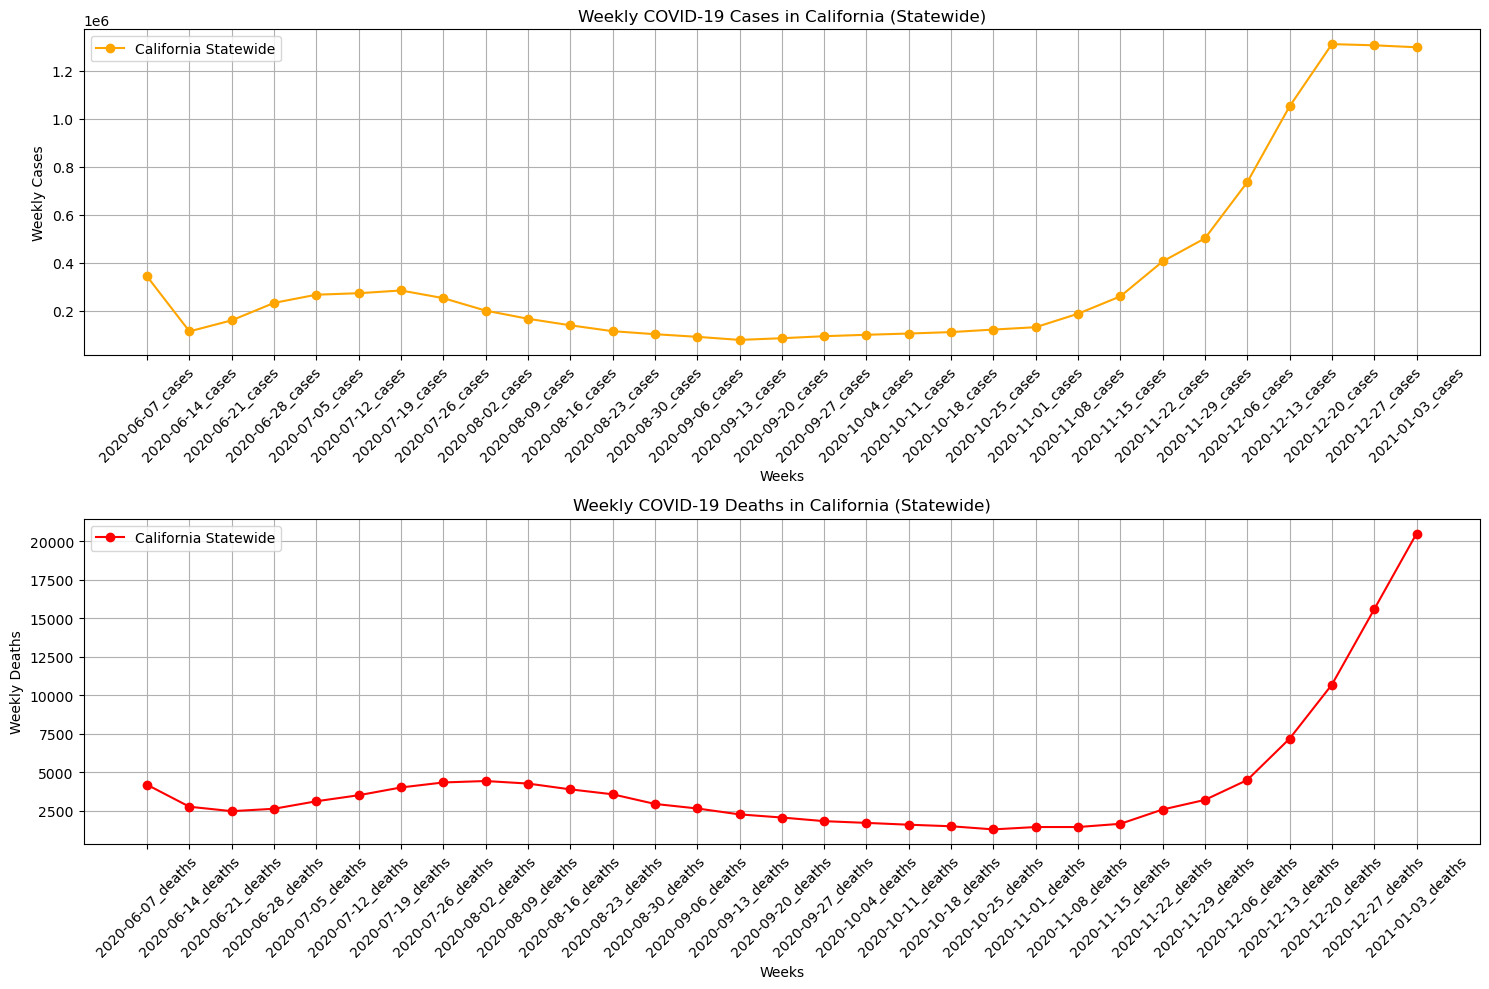

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load California data
df_cases = pd.read_csv('CA_weekly_cases.csv')
df_deaths = pd.read_csv('CA_weekly_deaths.csv')

# 5 chosen counties in California
desired_counties = ['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'San Bernardino']

# Regex pattern that matches any of the desired counties followed by " County"
pattern = '|'.join([f'{county} County' for county in desired_counties])

# Filter the rows in df_cases and df_deaths
df_ca_cases_filtered = df_cases[df_cases['County Name_x'].str.contains(pattern, regex=True)]
df_ca_deaths_filtered = df_deaths[df_deaths['County Name_x'].str.contains(pattern, regex=True)]

# Assuming the column names for weekly cases and deaths end with '_cases' and '_deaths' respectively
case_columns = [col for col in df_ca_cases_filtered.columns if '_cases' in col]
death_columns = [col for col in df_ca_deaths_filtered.columns if '_deaths' in col]

# Calculate and plot state-level trends for comparison
ca_statewide_cases = df_ca_cases_filtered[case_columns].sum(axis=0)
ca_statewide_deaths = df_ca_deaths_filtered[death_columns].sum(axis=0)

plt.figure(figsize=(15, 10))

# Plot state-level cases
plt.subplot(2, 1, 1)
plt.plot(ca_statewide_cases.index, ca_statewide_cases, marker='o', color='orange', label='California Statewide')
plt.title('Weekly COVID-19 Cases in California (Statewide)')
plt.xlabel('Weeks')
plt.ylabel('Weekly Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Plot state-level deaths
plt.subplot(2, 1, 2)
plt.plot(ca_statewide_deaths.index, ca_statewide_deaths, marker='o', color='r', label='California Statewide')
plt.title('Weekly COVID-19 Deaths in California (Statewide)')
plt.xlabel('Weeks')
plt.ylabel('Weekly Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('state_wide_cases_and_deaths.jpg') 
plt.show()


#### With the exception of Los Angeles County the counties do follow the statewide pattern (both in cases and deaths) just by looking at both graphs (although it is important to note that the cases for counties are all slightly higher than the statewide pattern, but still look identical in their line patterns)

## All steps have been completed!